# Reinforcement Learning from Scratch Part 1: Finding the Optimal Policy of an Environment Fully Defined within a Python Notebook


## Solving an Example Task of Throwing Paper into a Bin

This notebook attempts to solve a basic task of throwing paper into a bin using reinforcement learning. In this problem, we may throw from any position in the room but the probability of it is relative to the current distance from the bin and the direction in which the paper is thrown. Therefore the actions available are to throw the paper in any 360 degree direction or move to a new position to try and increase the probability that a throw made will go into the bin.

We solve the problem where the bin's location is not know but the environment model is and can be solved directly with Value-Iteration methods before showing how RL can be used similarly to find the optimal policy.

Furthermore, we introduce the option to add control to the environment where, for example, we can punish the algorithm less for missed throws so that the algorithm will take higher risks.

Lastly, we demonstrate how the envrionment can be changed and, for example, may have walls blocking throws from certain positions.

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from plotly.offline import init_notebook_mode, iplot, plot
from IPython.display import display, HTML
import plotly
#import chart_studio.plotly as py

init_notebook_mode(connected=True)
from IPython.display import clear_output

In [2]:
def probability(bin_x, bin_y, state_x, state_y, throw_deg):


    #First throw exception rule if person is directly on top of bin:
    if((state_x==bin_x) & (state_y==bin_y)):
        probability = 1
    else:
        
        
        # To accomodate for going over the 0 degree line
        if((throw_deg>270) & (state_x<=bin_x) & (state_y<=bin_y)):
            throw_deg = throw_deg - 360
        elif((throw_deg<90) & (state_x>bin_x) & (state_y<bin_y)):
            throw_deg = 360 + throw_deg
        else:
            throw_deg = throw_deg
            
        # Calculate Euclidean distance
        distance = ((bin_x - state_x)**2 + (bin_y - state_y)**2)**0.5

        # max distance for bin will always be on of the 4 corner points:
        corner_x = [-10,-10,10,10]
        corner_y = [-10,10,-10,10]
        dist_table = pd.DataFrame()
        for corner in range(0,4):
            dist = pd.DataFrame({'distance':((bin_x - corner_x[corner])**2 + (bin_y - corner_y[corner])**2)**0.5}, index = [corner])
            dist_table = dist_table.append(dist)
        dist_table = dist_table.reset_index()
        dist_table = dist_table.sort_values('distance', ascending = False)
        max_dist = dist_table['distance'][0]
        
        distance_score = 1 - (distance/max_dist)


        # First if person is directly horizontal or vertical of bin:
        if((state_x==bin_x) & (state_y>bin_y)):
            direction = 180
        elif((state_x==bin_x) & (state_y<bin_y)):
             direction = 0
        
        elif((state_x>bin_x) & (state_y==bin_y)):
             direction = 270
        elif((state_x<bin_x) & (state_y==bin_y)):
             direction = 90
              
        # If person is north-east of bin:
        elif((state_x>bin_x) & (state_y>bin_y)):
            opp = abs(bin_x - state_x)
            adj = abs(bin_y - state_y)
            direction = 180 +  np.degrees(np.arctan(opp/adj))

        # If person is south-east of bin:
        elif((state_x>bin_x) & (state_y<bin_y)):
            opp = abs(bin_y - state_y)
            adj = abs(bin_x - state_x)
            direction = 270 +  np.degrees(np.arctan(opp/adj))

        # If person is south-west of bin:
        elif((state_x<bin_x) & (state_y<bin_y)):
            opp = abs(bin_x - state_x)
            adj = abs(bin_y - state_y)
            direction =  np.degrees(np.arctan(opp/adj))

        # If person is north-west of bin:
        elif((state_x<bin_x) & (state_y>bin_y)):
            opp = abs(bin_y - state_y)
            adj = abs(bin_x - state_x)
            direction = 90 +  np.degrees(np.arctan(opp/adj))

        direction_score = (45-abs(direction - throw_deg))/45
      
        probability = distance_score*direction_score
        if(probability>0):
            probability = probability
        else:
            probability = 0
        
    return(probability)
    
bin_x = 0
bin_y = 0

prob_table = pd.DataFrame()
for z in range(0,37):
    throw_direction = z*10
    for i in range(0,20):
        state_x = -10 + i
        for j in range(0,20):
            state_y = -10 + j
            prob = pd.DataFrame({'throw_dir':throw_direction,'x':state_x,'y':state_y,'prob':probability(bin_x, bin_y, state_x, state_y, throw_direction)}, index = [0])
            prob_table = prob_table.append(prob)
prob_table = prob_table.reset_index(drop=True)

## Part 2: Optimal Policy for Environment with Known Probabilities

### 2.1 Model-based Methods
The aim is for us to find the optimal action in each state by either throwing or moving in a given direction. Because we have known probabilities, we can actually use model-based methods and will demonstrate this first and can use value iteration to achieve this via the following formula:

\begin{equation}
    Q_{k+1}(s,a) =  \sum^{s'}{P(s'|s,a) (R(s,a,s')+ γVk(s'))} \ for \ k ≥ 0
\end{equation}
where
\begin{equation}
    V_k(s) = max_a \ Qk(s,a) \ for \ k>0.
\end{equation}

$P(s'|s,a)$ is the probability of reaching the next state given the current state and action. We have defined this as 1 for movement actions and calculated by the probability function otherwise.

$R(s,a,s')$ corresponds to the reward for reaching the next state given the current state and action. 

Gamma will effect what our algorithm values more important whether it be short of long term rewards and a value close to 1 will value long term rewards more.

Value iteration starts with an arbitrary function V0 and uses the following equations to get the functions for k+1 stages to go from the functions for k stages to go (https://artint.info/html/ArtInt_227.html).



### 2.2 Initialise State-Action Pairs
Before applying the algorithm, we intialise each state-action value into a table. First we formthis for all throwing actions then all moving actions. 

We can throw in any direction and therefore there are 360 actions for each degree starting from north as 0 clockwise to 359 degrees. 

Although movement may seem simpler in that there are 8 possible actions (north, north east, east, etc) there are complications in that unlike being able to throw in any direction from any position, there are some movements that aren't possible. For example, if we are at the edge of the room, we cannot move beyong the boundary and this needs to be accounted for. Although this could be coded nicer, I have done this manually with the if/elif statements shown that skips the row if the position and movement is not possible. 


In [11]:
#Define Q(s,a) table by all possible states and THROW actions initialised to 0
Q_table = pd.DataFrame()
for z in range(0,360):
    clear_output(wait=True)
    print("Progress: ", np.round(z/360*100,2), "%")
    throw_direction = int(z)
    for i in range(0,21):
        state_x = int(-10 + i)
        for j in range(0,21):
            state_y = int(-10 + j)
            reward = 0
            Q = pd.DataFrame({'throw_dir':throw_direction,'move_dir':"none",'state_x':state_x,'state_y':state_y,'Q':0, 'reward': reward}, index = [0])
            Q_table = Q_table.append(Q)
Q_table = Q_table.reset_index(drop=True)
print("Q table 1 initialised")
Q_table.head()

Progress:  99.72 %
Q table 1 initialised


,throw_dir,move_dir,state_x,state_y,Q,reward
0,0,none,-10,-10,0,0
1,0,none,-10,-9,0,0
2,0,none,-10,-8,0,0
3,0,none,-10,-7,0,0
4,0,none,-10,-6,0,0


In [13]:
#Define Q(s,a) table by all possible states and MOVE actions initialised to 0

for x in range(0,21):
    clear_output(wait=True)
    print("Progress: ", np.round(x/21*100,2), "%")
    state_x = int(-10 + x)
    for y in range(0,21):
        state_y = int(-10 + y)
        for m in range(0,8):
            move_dir = int(m)
            
            # skip impossible moves starting with 4 corners then edges
            if((state_x==10)&(state_y==10)&(move_dir==0)):
                continue
            elif((state_x==10)&(state_y==10)&(move_dir==2)):
                continue
                
            elif((state_x==10)&(state_y==-10)&(move_dir==2)):
                continue
            elif((state_x==10)&(state_y==-10)&(move_dir==4)):
                continue
                
            elif((state_x==-10)&(state_y==-10)&(move_dir==4)):
                continue
            elif((state_x==-10)&(state_y==-10)&(move_dir==6)):
                continue
                
            elif((state_x==-10)&(state_y==10)&(move_dir==6)):
                continue
            elif((state_x==-10)&(state_y==10)&(move_dir==0)):
                continue
                
            elif((state_x==10) & (move_dir == 1)):
                continue
            elif((state_x==10) & (move_dir == 2)):
                continue
            elif((state_x==10) & (move_dir == 3)):
                continue
                 
            elif((state_x==-10) & (move_dir == 5)):
                continue
            elif((state_x==-10) & (move_dir == 6)):
                continue
            elif((state_x==-10) & (move_dir == 7)):
                continue
                 
            elif((state_y==10) & (move_dir == 1)):
                continue
            elif((state_y==10) & (move_dir == 0)):
                continue
            elif((state_y==10) & (move_dir == 7)):
                continue
                 
            elif((state_y==-10) & (move_dir == 3)):
                continue
            elif((state_y==-10) & (move_dir == 4)):
                continue
            elif((state_y==-10) & (move_dir == 5)):
                continue
                 
            else:
                reward = 0
                Q = pd.DataFrame({'throw_dir':"none",'move_dir':move_dir,'state_x':state_x,'state_y':state_y,'Q':0, 'reward': reward}, index = [0])
                Q_table = Q_table.append(Q)
Q_table = Q_table.reset_index(drop=True)
print("Q table 2 initialised")
Q_table.tail()

Progress:  95.24 %
Q table 2 initialised


,throw_dir,move_dir,state_x,state_y,Q,reward
163703,none,6,10,9,0,0
163704,none,7,10,9,0,0
163705,none,4,10,10,0,0
163706,none,5,10,10,0,0
163707,none,6,10,10,0,0


In [14]:
Q_table[(Q_table['state_x']==-10) &(Q_table['throw_dir']=="none")].head(5)

,throw_dir,move_dir,state_x,state_y,Q,reward
158760,none,0,-10,-10,0,0
158761,none,1,-10,-10,0,0
158762,none,2,-10,-10,0,0
158763,none,0,-10,-9,0,0
158764,none,1,-10,-9,0,0


### 2.3 Value-Iteration Optimal Policy

We start by initialising V(s) for all states, calculate the Q(s,a) matrix from this then update V(s) accordingly. This is repeated back and forth until the results converge. 

Next, we calculate the probability of each state-action pair using the function introduced previously if a thrown action or simply 1 if a move action.

We are now ready to apply the Value-Iteration and introduce the two parameters gamma and the number of iterations/repeats. Gamma will effect what our algorithm values more important whether it be short of long term rewards and a value close to 1 will value long term rewards more.

*"Different values of gamma may produce different policies. Lower gamma values will put more weight on short-term gains, whereas higher gamma values will put more weight towards long-term gains. Asymptotically, the closer gamma is to 1, the closer the policy will be to one that optimizes the gains over infinite time. On the other hand, value iteration will be slower to converge.*

*The best gamma depends on your domain. Sometimes it makes sense to look for short term gains (e.g. money gained sooner is actually more valuable than the same amount earned later), other times you want to look as far ahead as you can. And i would say that for a given MDP, there is probably a point (for high values of gamma) where the optimal policies will stabilize (no longer change when you increase gamma even more)."* https://stats.stackexchange.com/questions/137590/mdp-value-iteration-choosing-gamma

The number of iterations required to converge depends entirely on the scale of the problem, we will simply try some reasonable values and then observe the results after to find the optimal value. 


In [15]:
Q_table_VI = Q_table.copy()

In [16]:
Q_table_VI['V'] = 0

In [17]:
bin_x = 0
bin_y = 0

prob_list = pd.DataFrame()
for n,action in enumerate(Q_table_VI['throw_dir']):
    # Guarantee 100% probability if movement
    if(action == "none"):
        prob = 1
    # Calculate if thrown
    else:
        prob = probability(bin_x, bin_y, Q_table_VI['state_x'][n], Q_table_VI['state_y'][n], action)
    prob_list = prob_list.append(pd.DataFrame({'prob':prob}, index = [n] ))
prob_list = prob_list.reset_index(drop=True)
Q_table_VI['prob'] = prob_list['prob']

In [18]:
Q_table_VI.head(5)

,throw_dir,move_dir,state_x,state_y,Q,reward,V,prob
0,0,none,-10,-10,0,0,0,0.0
1,0,none,-10,-9,0,0,0,0.0
2,0,none,-10,-8,0,0,0,0.0
3,0,none,-10,-7,0,0,0,0.0
4,0,none,-10,-6,0,0,0,0.0


In [19]:
Q_table_VI[ (Q_table_VI['state_x']==-1) & (Q_table_VI['state_y']==-1) & (Q_table_VI['throw_dir']==45)]

,throw_dir,move_dir,state_x,state_y,Q,reward,V,prob
20043,45,none,-1,-1,0,0,0,0.9


#### Extra Code Features: Tracking loop progress and run-time
To improve our code, we introduce two useful tools for keep track of the run time. First, we import 'time' and then use this to calculate how long the Value Iteration algorithm thats to run for the given inputs.

Secondly, which I have found extremely useful for algorithms that take more than a few minutes to run, is to introduce a simple way of tracking the current progress. In short, we print the current iteration and clear this output after each stage using the second import. More info can be found here: https://www.philiposbornedata.com/2018/06/28/the-simplest-cleanest-method-for-tracking-a-for-loops-progress-and-expected-run-time-in-python-notebooks/

In [20]:
import time
from IPython.display import clear_output

In [21]:
input_table = Q_table_VI.copy()
gamma = 0.8
num_repeats = 5

start_time = time.time()

output_metric_table = pd.DataFrame()
# Repeat until converges
for repeats in range(0,num_repeats):
    clear_output(wait=True)
    state_sub_full = pd.DataFrame()
    
    
    output_metric_table = output_metric_table.append(pd.DataFrame({'mean_Q':input_table['Q'].mean(), 
                                                                   'sum_Q': input_table['Q'].sum(),
                                                                   'mean_V':input_table[['state_x', 'state_y','V']].drop_duplicates(['state_x', 'state_y', 'V'])['V'].mean(),
                                                                   'sum_V': input_table[['state_x', 'state_y','V']].drop_duplicates(['state_x', 'state_y', 'V'])['V'].sum()}, index = [repeats]))
    
    
    # Iterate over all states defined by max - min of x times by max - min of y
    for x in range(0,21):
        state_x = -10 + x
        for y in range(0,21):
            state_y = -10 + y

            state_sub = input_table[ (input_table['state_x']==state_x) & (input_table['state_y']==state_y)]
            Q_sub_list = pd.DataFrame()
            for n, action in state_sub.iterrows():
                # Move action update Q
                if(action['throw_dir'] == "none"):
                    move_direction = action['move_dir']
                    #Map this to actual direction and find V(s) for next state
                    if(move_direction == 0):
                        move_x = 0
                        move_y = 1
                    elif(move_direction == 1):
                        move_x = 1
                        move_y = 1
                    elif(move_direction == 2):
                        move_x = 1
                        move_y = 0
                    elif(move_direction == 3):
                        move_x = 1
                        move_y = -1
                    elif(move_direction == 4):
                        move_x = 0
                        move_y = -1
                    elif(move_direction == 5):
                        move_x = -1
                        move_y = -1
                    elif(move_direction == 6):
                        move_x = -1
                        move_y = 0
                    elif(move_direction == 7):
                        move_x = -1
                        move_y = 1
                    Q = 1*(action['reward'] + gamma*max(input_table[ (input_table['state_x']==int(state_x+move_x)) & (input_table['state_y']==int(state_y+move_y))]['V']) )
                # Throw update Q +1 if sucessful throw or -1 if failed
                else:
                    Q = (action['prob']*(action['reward'] + gamma*1)) +  ((1-action['prob'])*(action['reward'] + gamma*-1))
                Q_sub_list = Q_sub_list.append(pd.DataFrame({'Q':Q}, index = [n]))
            state_sub['Q'] = Q_sub_list['Q']
            state_sub['V'] = max(state_sub['Q'])
            state_sub_full = state_sub_full.append(state_sub)
            
            

    
            
    input_table = state_sub_full.copy()
    print("Repeats completed: ", np.round((repeats+1)/num_repeats,2)*100, "%")
    
end_time = time.time()

print("total time taken this loop: ", np.round((end_time - start_time)/60,2), " minutes")

Repeats completed:  100.0 %
total time taken this loop:  31.5  minutes


#### Analysing Value-Iteration Output
We therefore have our output table that shows the quality of each state-action pair and the corresponding V value. 

First, we need to conisder whether this has converged to the optimal value and can plot the mean Q values for each update. Clearly after just 10 iterations this has not converged and will need to increase this to a suitable value. It took 20 miinutes to run for 10 iterations and so we can assume that it take approximately 2 per iteration.

In [22]:
state_sub_full.head(3)

,throw_dir,move_dir,state_x,state_y,Q,reward,V,prob
0,0,none,-10,-10,-0.8,0,0.0,0.0
441,1,none,-10,-10,-0.8,0,0.0,0.0
882,2,none,-10,-10,-0.8,0,0.0,0.0


In [23]:
state_sub_full[ (state_sub_full['state_x']==-4) & (state_sub_full['state_y']==-4) & (state_sub_full['Q']== max(state_sub_full[ (state_sub_full['state_x']==-4) & (state_sub_full['state_y']==-4)]['Q']))]

,throw_dir,move_dir,state_x,state_y,Q,reward,V,prob
159717,none,1,-4,-4,0.32768,0,0.32768,1.0
161385,none,1,-4,-4,0.32768,0,0.32768,1.0


In [24]:
output_metric_table

,mean_Q,sum_Q,mean_V,sum_V
0,0.000000,0.000000,0.000000,0.000000
1,-0.688875,-112774.353625,0.093130,41.070179
2,-0.686390,-112367.583980,0.122433,53.992804
3,-0.685631,-112243.286204,0.149159,65.779058
4,-0.684940,-112130.138163,0.173167,76.366585


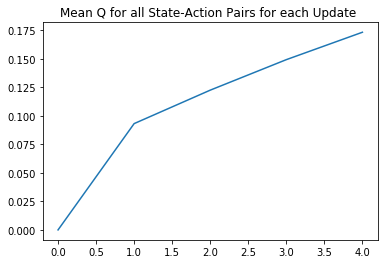

In [25]:
plt.plot(range(0,len(output_metric_table)), output_metric_table['mean_V'])
plt.title("Mean Q for all State-Action Pairs for each Update ")
plt.show()

#### Finding the Optimal Policy for Given Results

Although we know this hasn't fully converged yet, if we assume it has for now we can begin to analyse the results to find the optimal action in any given state. The optimal action is the one that has the highest Q value for th given state and is found for each state in the cell below. 

In [26]:
Q_table_VI_3 = state_sub_full.copy()

In [27]:
optimal_action_list = pd.DataFrame()
for x in range(0,21):
    state_x = int(-10 + x)
    for y in range(0,21):
        state_y = int(-10 + y)
        
        Q_table_VI_3
        
        optimal_action = pd.DataFrame({'state_x':state_x, 'state_y': state_y, 
                                      'move_dir': Q_table_VI_3[ (Q_table_VI_3['state_x']==state_x) & (Q_table_VI_3['state_y']==state_y) &  (Q_table_VI_3['Q'] == max(Q_table_VI_3[(Q_table_VI_3['state_x']==state_x) & 
                                                      (Q_table_VI_3['state_y']==state_y)]['Q']))].reset_index(drop=True)['move_dir'][0],
                                      'throw_dir': Q_table_VI_3[ (Q_table_VI_3['state_x']==state_x) & (Q_table_VI_3['state_y']==state_y) &  (Q_table_VI_3['Q'] == max(Q_table_VI_3[(Q_table_VI_3['state_x']==state_x) & 
                                                      (Q_table_VI_3['state_y']==state_y)]['Q']))].reset_index(drop=True)['throw_dir'][0]},
                                     index = [state_y])
        optimal_action_list = optimal_action_list.append(optimal_action)
optimal_action_list = optimal_action_list.reset_index(drop=True)

In [28]:
optimal_action_list.head(5)

,state_x,state_y,move_dir,throw_dir
0,-10,-10,0,none
1,-10,-9,0,none
2,-10,-8,0,none
3,-10,-7,1,none
4,-10,-6,1,none


In [29]:
optimal_action_list[(optimal_action_list['state_x']==-1)&(optimal_action_list['state_y']==-1)]

,state_x,state_y,move_dir,throw_dir
198,-1,-1,none,45


In [30]:
optimal_action_list['Action'] = np.where( optimal_action_list['move_dir'] == 'none', 'THROW', 'MOVE'  )

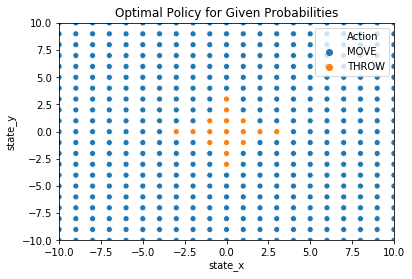

In [31]:
sns.scatterplot( x="state_x", y="state_y", data=optimal_action_list,  hue='Action')
plt.title("Optimal Policy for Given Probabilities")
plt.ylim([-10,10])
plt.xlim([-10,10])
plt.show()

#### Improving Visualisation of Optimal Policy

Although the chart shows whether the optimal action is either a throw or move it doesn't show us which direction these are in. Therefore, we will map each optimal action to a vector of u and v and use these to create a quiver plot (https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.quiver.html). 

First, we map the move direction to its x and y components and set the actions which are throwing (currently labelled as "none") in column to a very large negative integer so we do not have issues when we want to scale the values in the column by a factor. If we didnt do this we would recieve an error as we would be trying to divide a string element by a number and this isn't possible. We repeat this for the throw direction column as well.

We then define the scale of the arrows and use this to define the horizontal component labelled u. For movement actions, we simply multiply the movement in the x direction by this factor and for the throw direction we either move 1 unit left or right (accounting for no horizontal movement for 0 or 180 degrees and no vertical movement at 90 or 270 degrees). 

The horizontal component is then used to calculate the vertical component with some basic trigonometry where we again account for certain angles that would cause errors in the calculations. 

In [32]:
optimal_action_list['move_x'] = np.where(optimal_action_list['move_dir'] == 0, int(0),
                                         np.where(optimal_action_list['move_dir'] == 1, int(1),
                                         np.where(optimal_action_list['move_dir'] == 2, int(1),
                                         np.where(optimal_action_list['move_dir'] == 3, int(1),
                                         np.where(optimal_action_list['move_dir'] == 4, int(0),
                                         np.where(optimal_action_list['move_dir'] == 5, int(-1),
                                         np.where(optimal_action_list['move_dir'] == 6, int(-1),
                                         np.where(optimal_action_list['move_dir'] == 7, int(-1),
                                         int(-1000)
                                        ))))))))
optimal_action_list['move_y'] = np.where(optimal_action_list['move_dir'] == 0, int(1),
                                         np.where(optimal_action_list['move_dir'] == 1, int(1),
                                         np.where(optimal_action_list['move_dir'] == 2, int(0),
                                         np.where(optimal_action_list['move_dir'] == 3, int(-1),
                                         np.where(optimal_action_list['move_dir'] == 4, int(-1),
                                         np.where(optimal_action_list['move_dir'] == 5, int(-1),
                                         np.where(optimal_action_list['move_dir'] == 6, int(0),
                                         np.where(optimal_action_list['move_dir'] == 7, int(1),
                                         int(-1000)
                                        ))))))))
optimal_action_list['throw_dir_2'] = np.where(optimal_action_list['throw_dir']=="none",int(-1000), optimal_action_list['throw_dir'])
optimal_action_list.head(10)

,state_x,state_y,move_dir,throw_dir,Action,move_x,move_y,throw_dir_2
0,-10,-10,0,none,MOVE,0,1,-1000
1,-10,-9,0,none,MOVE,0,1,-1000
2,-10,-8,0,none,MOVE,0,1,-1000
3,-10,-7,1,none,MOVE,1,1,-1000
4,-10,-6,1,none,MOVE,1,1,-1000
5,-10,-5,1,none,MOVE,1,1,-1000
6,-10,-4,1,none,MOVE,1,1,-1000
7,-10,-3,1,none,MOVE,1,1,-1000
8,-10,-2,1,none,MOVE,1,1,-1000
9,-10,-1,1,none,MOVE,1,1,-1000


In [33]:
arrow_scale = 0.1

In [34]:
# Define horizontal arrow component as 0.1*move direction or 0.1/-0.1 depending on throw direction
optimal_action_list['u'] = np.where(optimal_action_list['Action']=="MOVE", optimal_action_list['move_x']*arrow_scale,
                                    np.where(optimal_action_list['throw_dir_2']==0, 0,np.where(optimal_action_list['throw_dir_2']==180, 0,
                                    np.where(optimal_action_list['throw_dir_2']==90, arrow_scale ,np.where(optimal_action_list['throw_dir_2']==270, -arrow_scale,
                                    np.where(optimal_action_list['throw_dir_2']<180, arrow_scale,-arrow_scale))))))
optimal_action_list.head(5)

,state_x,state_y,move_dir,throw_dir,Action,move_x,move_y,throw_dir_2,u
0,-10,-10,0,none,MOVE,0,1,-1000,0.0
1,-10,-9,0,none,MOVE,0,1,-1000,0.0
2,-10,-8,0,none,MOVE,0,1,-1000,0.0
3,-10,-7,1,none,MOVE,1,1,-1000,0.1
4,-10,-6,1,none,MOVE,1,1,-1000,0.1


In [35]:
# Define vertical arrow component based 0.1*move direciton or +/- u*tan(throw_dir) accordingly
optimal_action_list['v'] = np.where(optimal_action_list['Action']=="MOVE", optimal_action_list['move_y']*arrow_scale, 
                                    np.where(optimal_action_list['throw_dir_2']==0, arrow_scale,np.where(optimal_action_list['throw_dir_2']==180, -arrow_scale,
                                    np.where(optimal_action_list['throw_dir_2']==90, 0,np.where(optimal_action_list['throw_dir_2']==270, 0,
                                    optimal_action_list['u']/np.tan(np.deg2rad(optimal_action_list['throw_dir_2'].astype(np.float64))))))))
optimal_action_list.head(5)

,state_x,state_y,move_dir,throw_dir,Action,move_x,move_y,throw_dir_2,u,v
0,-10,-10,0,none,MOVE,0,1,-1000,0.0,0.1
1,-10,-9,0,none,MOVE,0,1,-1000,0.0,0.1
2,-10,-8,0,none,MOVE,0,1,-1000,0.0,0.1
3,-10,-7,1,none,MOVE,1,1,-1000,0.1,0.1
4,-10,-6,1,none,MOVE,1,1,-1000,0.1,0.1


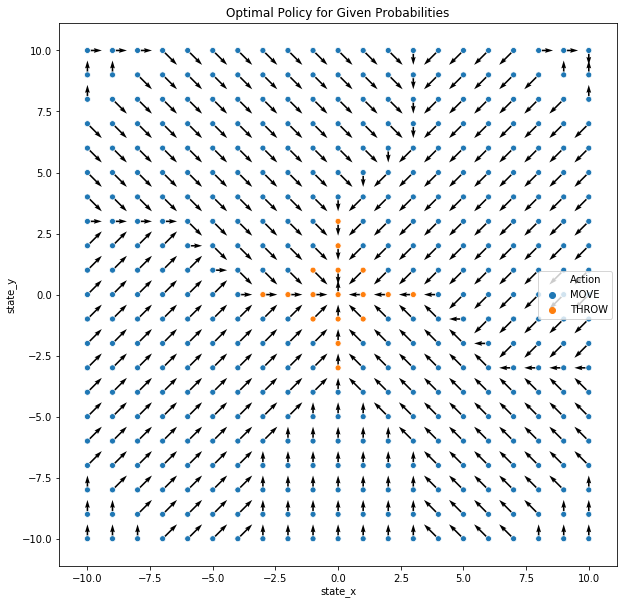

In [36]:
x = optimal_action_list['state_x']
y = optimal_action_list['state_y']
u = optimal_action_list['u'].values
v = optimal_action_list['v'].values
plt.figure(figsize=(10, 10))
plt.quiver(x,y,u,v,scale=0.5,scale_units='inches')
sns.scatterplot( x="state_x", y="state_y", data=optimal_action_list,  hue='Action')
plt.title("Optimal Policy for Given Probabilities")
plt.show()


#### We can combine the previous code for creating the quiver plot into one code cell

In [37]:
# Create Quiver plot showing current optimal policy in one cell
arrow_scale = 0.1

Q_table_VI_3 = state_sub_full.copy()

optimal_action_list = pd.DataFrame()
for x in range(0,21):
    state_x = int(-10 + x)
    for y in range(0,21):
        state_y = int(-10 + y)
        
        Q_table_VI_3
        
        optimal_action = pd.DataFrame({'state_x':state_x, 'state_y': state_y, 
                                      'move_dir': Q_table_VI_3[ (Q_table_VI_3['state_x']==state_x) & (Q_table_VI_3['state_y']==state_y) &  (Q_table_VI_3['Q'] == max(Q_table_VI_3[(Q_table_VI_3['state_x']==state_x) & 
                                                      (Q_table_VI_3['state_y']==state_y)]['Q']))].reset_index(drop=True)['move_dir'][0],
                                      'throw_dir': Q_table_VI_3[ (Q_table_VI_3['state_x']==state_x) & (Q_table_VI_3['state_y']==state_y) &  (Q_table_VI_3['Q'] == max(Q_table_VI_3[(Q_table_VI_3['state_x']==state_x) & 
                                                      (Q_table_VI_3['state_y']==state_y)]['Q']))].reset_index(drop=True)['throw_dir'][0]},
                                     index = [state_y])
        optimal_action_list = optimal_action_list.append(optimal_action)
optimal_action_list = optimal_action_list.reset_index(drop=True)

optimal_action_list['Action'] = np.where( optimal_action_list['move_dir'] == 'none', 'THROW', 'MOVE'  )


optimal_action_list['move_x'] = np.where(optimal_action_list['move_dir'] == 0, int(0),
                                         np.where(optimal_action_list['move_dir'] == 1, int(1),
                                         np.where(optimal_action_list['move_dir'] == 2, int(1),
                                         np.where(optimal_action_list['move_dir'] == 3, int(1),
                                         np.where(optimal_action_list['move_dir'] == 4, int(0),
                                         np.where(optimal_action_list['move_dir'] == 5, int(-1),
                                         np.where(optimal_action_list['move_dir'] == 6, int(-1),
                                         np.where(optimal_action_list['move_dir'] == 7, int(-1),
                                         int(-1000)
                                        ))))))))
optimal_action_list['move_y'] = np.where(optimal_action_list['move_dir'] == 0, int(1),
                                         np.where(optimal_action_list['move_dir'] == 1, int(1),
                                         np.where(optimal_action_list['move_dir'] == 2, int(0),
                                         np.where(optimal_action_list['move_dir'] == 3, int(-1),
                                         np.where(optimal_action_list['move_dir'] == 4, int(-1),
                                         np.where(optimal_action_list['move_dir'] == 5, int(-1),
                                         np.where(optimal_action_list['move_dir'] == 6, int(0),
                                         np.where(optimal_action_list['move_dir'] == 7, int(1),
                                         int(-1000)
                                        ))))))))
optimal_action_list['throw_dir_2'] = np.where(optimal_action_list['throw_dir']=="none",int(-1000), optimal_action_list['throw_dir'])

# Define horizontal arrow component as 0.1*move direction or 0.1/-0.1 depending on throw direction
optimal_action_list['u'] = np.where(optimal_action_list['Action']=="MOVE", optimal_action_list['move_x']*arrow_scale,
                                    np.where(optimal_action_list['throw_dir_2']==0, 0,np.where(optimal_action_list['throw_dir_2']==180, 0,
                                    np.where(optimal_action_list['throw_dir_2']==90, arrow_scale ,np.where(optimal_action_list['throw_dir_2']==270, -arrow_scale,
                                    np.where(optimal_action_list['throw_dir_2']<180, arrow_scale,-arrow_scale))))))
                                             
# Define vertical arrow component based 0.1*move direciton or +/- u*tan(throw_dir) accordingly
optimal_action_list['v'] = np.where(optimal_action_list['Action']=="MOVE", optimal_action_list['move_y']*arrow_scale, 
                                    np.where(optimal_action_list['throw_dir_2']==0, arrow_scale,np.where(optimal_action_list['throw_dir_2']==180, -arrow_scale,
                                    np.where(optimal_action_list['throw_dir_2']==90, 0,np.where(optimal_action_list['throw_dir_2']==270, 0,
                                    optimal_action_list['u']/np.tan(np.deg2rad(optimal_action_list['throw_dir_2'].astype(np.float64))))))))
                                             
x = optimal_action_list['state_x']
y = optimal_action_list['state_y']
u = optimal_action_list['u'].values
v = optimal_action_list['v'].values

#plt.figure(figsize=(10, 10))
#plt.quiver(x,y,u,v,scale=0.5,scale_units='inches')
#sns.scatterplot( x="state_x", y="state_y", data=optimal_action_list,  hue='Action')
#plt.title("Optimal Policy for Given Probabilities")
#plt.show()



### 2.4 Increasing the number of iterations

We now re-apply the value-iteration algorithm and the subsequent evaluation but increase the number of repeats from 5 to 10 and find that our policy coverges to the optimal one within this. 

#### To demonstrate the change over each iteration further, I have included an export of the quiver plot analysis for each iteration and combined these into a small animation. The export is commented out in this published notebook but can be used in your own.



In [38]:
input_table = Q_table_VI.copy()
gamma = 0.8
num_repeats = 15

start_time = time.time()

output_metric_table = pd.DataFrame()
# Repeat until converges
for repeats in range(0,num_repeats):
    clear_output(wait=True)
    state_sub_full = pd.DataFrame()
    
    
    output_metric_table = output_metric_table.append(pd.DataFrame({'mean_Q':input_table['Q'].mean(), 
                                                                   'sum_Q': input_table['Q'].sum(),
                                                                   'mean_V':input_table[['state_x', 'state_y','V']].drop_duplicates(['state_x', 'state_y', 'V'])['V'].mean(),
                                                                   'sum_V': input_table[['state_x', 'state_y','V']].drop_duplicates(['state_x', 'state_y', 'V'])['V'].sum()}, index = [repeats]))
    
    
    # Iterate over all states defined by max - min of x times by max - min of y
    for x in range(0,21):
        state_x = -10 + x
        for y in range(0,21):
            state_y = -10 + y

            state_sub = input_table[ (input_table['state_x']==state_x) & (input_table['state_y']==state_y)]
            Q_sub_list = pd.DataFrame()
            for n, action in state_sub.iterrows():
                # Move action update Q
                if(action['throw_dir'] == "none"):
                    move_direction = action['move_dir']
                    #Map this to actual direction and find V(s) for next state
                    if(move_direction == 0):
                        move_x = 0
                        move_y = 1
                    elif(move_direction == 1):
                        move_x = 1
                        move_y = 1
                    elif(move_direction == 2):
                        move_x = 1
                        move_y = 0
                    elif(move_direction == 3):
                        move_x = 1
                        move_y = -1
                    elif(move_direction == 4):
                        move_x = 0
                        move_y = -1
                    elif(move_direction == 5):
                        move_x = -1
                        move_y = -1
                    elif(move_direction == 6):
                        move_x = -1
                        move_y = 0
                    elif(move_direction == 7):
                        move_x = -1
                        move_y = 1
                    Q = 1*(action['reward'] + gamma*max(input_table[ (input_table['state_x']==int(state_x+move_x)) & (input_table['state_y']==int(state_y+move_y))]['V']) )
                # Throw update Q +1 if sucessful throw or -1 if failed
                else:
                    Q = (action['prob']*(action['reward'] + gamma*1)) +  ((1-action['prob'])*(action['reward'] + gamma*-1))
                Q_sub_list = Q_sub_list.append(pd.DataFrame({'Q':Q}, index = [n]))
            state_sub['Q'] = Q_sub_list['Q']
            state_sub['V'] = max(state_sub['Q'])
            state_sub_full = state_sub_full.append(state_sub)
            
    
    
    ###
    # Create Quiver plot showing current optimal policy in one cell
    arrow_scale = 0.1

    Q_table_VI_3 = state_sub_full.copy()

    optimal_action_list = pd.DataFrame()
    for x in range(0,21):
        state_x = int(-10 + x)
        for y in range(0,21):
            state_y = int(-10 + y)

            Q_table_VI_3

            optimal_action = pd.DataFrame({'state_x':state_x, 'state_y': state_y, 
                                          'move_dir': Q_table_VI_3[ (Q_table_VI_3['state_x']==state_x) & (Q_table_VI_3['state_y']==state_y) &  (Q_table_VI_3['Q'] == max(Q_table_VI_3[(Q_table_VI_3['state_x']==state_x) & 
                                                          (Q_table_VI_3['state_y']==state_y)]['Q']))].reset_index(drop=True)['move_dir'][0],
                                          'throw_dir': Q_table_VI_3[ (Q_table_VI_3['state_x']==state_x) & (Q_table_VI_3['state_y']==state_y) &  (Q_table_VI_3['Q'] == max(Q_table_VI_3[(Q_table_VI_3['state_x']==state_x) & 
                                                          (Q_table_VI_3['state_y']==state_y)]['Q']))].reset_index(drop=True)['throw_dir'][0]},
                                         index = [state_y])
            optimal_action_list = optimal_action_list.append(optimal_action)
    optimal_action_list = optimal_action_list.reset_index(drop=True)

    optimal_action_list['Action'] = np.where( optimal_action_list['move_dir'] == 'none', 'THROW', 'MOVE'  )


    optimal_action_list['move_x'] = np.where(optimal_action_list['move_dir'] == 0, int(0),
                                             np.where(optimal_action_list['move_dir'] == 1, int(1),
                                             np.where(optimal_action_list['move_dir'] == 2, int(1),
                                             np.where(optimal_action_list['move_dir'] == 3, int(1),
                                             np.where(optimal_action_list['move_dir'] == 4, int(0),
                                             np.where(optimal_action_list['move_dir'] == 5, int(-1),
                                             np.where(optimal_action_list['move_dir'] == 6, int(-1),
                                             np.where(optimal_action_list['move_dir'] == 7, int(-1),
                                             int(-1000)
                                            ))))))))
    optimal_action_list['move_y'] = np.where(optimal_action_list['move_dir'] == 0, int(1),
                                             np.where(optimal_action_list['move_dir'] == 1, int(1),
                                             np.where(optimal_action_list['move_dir'] == 2, int(0),
                                             np.where(optimal_action_list['move_dir'] == 3, int(-1),
                                             np.where(optimal_action_list['move_dir'] == 4, int(-1),
                                             np.where(optimal_action_list['move_dir'] == 5, int(-1),
                                             np.where(optimal_action_list['move_dir'] == 6, int(0),
                                             np.where(optimal_action_list['move_dir'] == 7, int(1),
                                             int(-1000)
                                            ))))))))
    optimal_action_list['throw_dir_2'] = np.where(optimal_action_list['throw_dir']=="none",int(-1000), optimal_action_list['throw_dir'])

    # Define horizontal arrow component as 0.1*move direction or 0.1/-0.1 depending on throw direction
    optimal_action_list['u'] = np.where(optimal_action_list['Action']=="MOVE", optimal_action_list['move_x']*arrow_scale,
                                        np.where(optimal_action_list['throw_dir_2']==0, 0,np.where(optimal_action_list['throw_dir_2']==180, 0,
                                        np.where(optimal_action_list['throw_dir_2']==90, arrow_scale ,np.where(optimal_action_list['throw_dir_2']==270, -arrow_scale,
                                        np.where(optimal_action_list['throw_dir_2']<180, arrow_scale,-arrow_scale))))))

    # Define vertical arrow component based 0.1*move direciton or +/- u*tan(throw_dir) accordingly
    optimal_action_list['v'] = np.where(optimal_action_list['Action']=="MOVE", optimal_action_list['move_y']*arrow_scale, 
                                        np.where(optimal_action_list['throw_dir_2']==0, arrow_scale,np.where(optimal_action_list['throw_dir_2']==180, -arrow_scale,
                                        np.where(optimal_action_list['throw_dir_2']==90, 0,np.where(optimal_action_list['throw_dir_2']==270, 0,
                                        optimal_action_list['u']/np.tan(np.deg2rad(optimal_action_list['throw_dir_2'].astype(np.float64))))))))



    x = optimal_action_list['state_x']
    y = optimal_action_list['state_y']
    u = optimal_action_list['u'].values
    v = optimal_action_list['v'].values
    plt.figure(figsize=(10, 10))
    plt.quiver(x,y,u,v,scale=0.5,scale_units='inches')
    sns.scatterplot( x="state_x", y="state_y", data=optimal_action_list,  hue='Action')
    plt.title("Optimal Policy for Given Probabilities for iteration " +str(repeats))
    #plt.savefig('E:\\Documents\\RL\\RL from scratch v2\\QuiverPlots\\'+str(repeats)+'.png')   # save the figure to file
    plt.close() 

    ###
    input_table = state_sub_full.copy()
    print("Repeats completed: ", np.round((repeats+1)/num_repeats,2)*100, "%")
    
end_time = time.time()

print("total time taken this loop: ", np.round((end_time - start_time)/60,2), " minutes")

Repeats completed:  100.0 %
total time taken this loop:  59.48  minutes


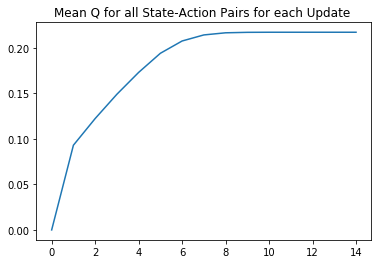

In [39]:
plt.plot(range(0,len(output_metric_table)), output_metric_table['mean_V'])
plt.title("Mean Q for all State-Action Pairs for each Update ")
plt.show()

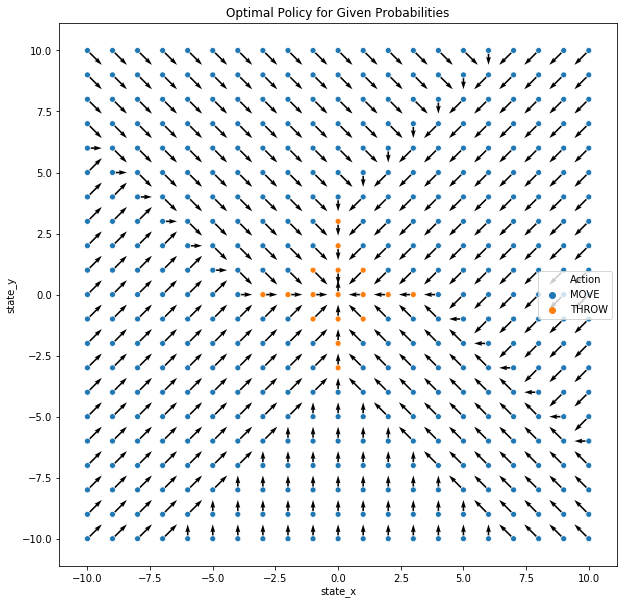

In [40]:
# Create Quiver plot showing current optimal policy in one cell
arrow_scale = 0.1

Q_table_VI_3 = state_sub_full.copy()

optimal_action_list = pd.DataFrame()
for x in range(0,21):
    state_x = int(-10 + x)
    for y in range(0,21):
        state_y = int(-10 + y)
        
        Q_table_VI_3
        
        optimal_action = pd.DataFrame({'state_x':state_x, 'state_y': state_y, 
                                      'move_dir': Q_table_VI_3[ (Q_table_VI_3['state_x']==state_x) & (Q_table_VI_3['state_y']==state_y) &  (Q_table_VI_3['Q'] == max(Q_table_VI_3[(Q_table_VI_3['state_x']==state_x) & 
                                                      (Q_table_VI_3['state_y']==state_y)]['Q']))].reset_index(drop=True)['move_dir'][0],
                                      'throw_dir': Q_table_VI_3[ (Q_table_VI_3['state_x']==state_x) & (Q_table_VI_3['state_y']==state_y) &  (Q_table_VI_3['Q'] == max(Q_table_VI_3[(Q_table_VI_3['state_x']==state_x) & 
                                                      (Q_table_VI_3['state_y']==state_y)]['Q']))].reset_index(drop=True)['throw_dir'][0]},
                                     index = [state_y])
        optimal_action_list = optimal_action_list.append(optimal_action)
optimal_action_list = optimal_action_list.reset_index(drop=True)

optimal_action_list['Action'] = np.where( optimal_action_list['move_dir'] == 'none', 'THROW', 'MOVE'  )


optimal_action_list['move_x'] = np.where(optimal_action_list['move_dir'] == 0, int(0),
                                         np.where(optimal_action_list['move_dir'] == 1, int(1),
                                         np.where(optimal_action_list['move_dir'] == 2, int(1),
                                         np.where(optimal_action_list['move_dir'] == 3, int(1),
                                         np.where(optimal_action_list['move_dir'] == 4, int(0),
                                         np.where(optimal_action_list['move_dir'] == 5, int(-1),
                                         np.where(optimal_action_list['move_dir'] == 6, int(-1),
                                         np.where(optimal_action_list['move_dir'] == 7, int(-1),
                                         int(-1000)
                                        ))))))))
optimal_action_list['move_y'] = np.where(optimal_action_list['move_dir'] == 0, int(1),
                                         np.where(optimal_action_list['move_dir'] == 1, int(1),
                                         np.where(optimal_action_list['move_dir'] == 2, int(0),
                                         np.where(optimal_action_list['move_dir'] == 3, int(-1),
                                         np.where(optimal_action_list['move_dir'] == 4, int(-1),
                                         np.where(optimal_action_list['move_dir'] == 5, int(-1),
                                         np.where(optimal_action_list['move_dir'] == 6, int(0),
                                         np.where(optimal_action_list['move_dir'] == 7, int(1),
                                         int(-1000)
                                        ))))))))
optimal_action_list['throw_dir_2'] = np.where(optimal_action_list['throw_dir']=="none",int(-1000), optimal_action_list['throw_dir'])

# Define horizontal arrow component as 0.1*move direction or 0.1/-0.1 depending on throw direction
optimal_action_list['u'] = np.where(optimal_action_list['Action']=="MOVE", optimal_action_list['move_x']*arrow_scale,
                                    np.where(optimal_action_list['throw_dir_2']==0, 0,np.where(optimal_action_list['throw_dir_2']==180, 0,
                                    np.where(optimal_action_list['throw_dir_2']==90, arrow_scale ,np.where(optimal_action_list['throw_dir_2']==270, -arrow_scale,
                                    np.where(optimal_action_list['throw_dir_2']<180, arrow_scale,-arrow_scale))))))

# Define vertical arrow component based 0.1*move direciton or +/- u*tan(throw_dir) accordingly
optimal_action_list['v'] = np.where(optimal_action_list['Action']=="MOVE", optimal_action_list['move_y']*arrow_scale, 
                                    np.where(optimal_action_list['throw_dir_2']==0, arrow_scale,np.where(optimal_action_list['throw_dir_2']==180, -arrow_scale,
                                    np.where(optimal_action_list['throw_dir_2']==90, 0,np.where(optimal_action_list['throw_dir_2']==270, 0,
                                    optimal_action_list['u']/np.tan(np.deg2rad(optimal_action_list['throw_dir_2'].astype(np.float64))))))))

x = optimal_action_list['state_x']
y = optimal_action_list['state_y']
u = optimal_action_list['u'].values
v = optimal_action_list['v'].values
plt.figure(figsize=(10, 10))
plt.quiver(x,y,u,v,scale=0.5,scale_units='inches')
sns.scatterplot( x="state_x", y="state_y", data=optimal_action_list,  hue='Action')
plt.title("Optimal Policy for Given Probabilities")
plt.show()



In [41]:
optimal_action_list [ (optimal_action_list['state_x']==-10) & (optimal_action_list['state_y']==0)].head()

,state_x,state_y,move_dir,throw_dir,Action,move_x,move_y,throw_dir_2,u,v
10,-10,0,1,none,MOVE,1,1,-1000,0.1,0.1


#### This figure shows the optimal policy defining the best action at each state. 

This may seem unusual at first as, for example, state (-10,0) seems as though it should move directly east if it wants to reach the goal faster but if we count the number of steps, as shown below, this is equal.

In fact, there are a number of optimal actions for many of the move states. Any state nots in the diagonal streams can move in any direction that tends towards to bin and still be optimal. i.e. state (-10,0) can move north-east, east or south-east and still be an optimal action. We have currently simply chosen the first one that appears but if we correct this we have the complete optimal policy shown below.

Furthermore, there may be some states where moving is just as optimal as throwing and we therefore reduce the alpha of each point's colour in an attempt to visualise those that have both.

![Imgur](https://i.imgur.com/n9aTN4b.png)

In [42]:
Q_table_VI_3 [ (Q_table_VI_3['state_x']==-5) & (Q_table_VI_3['state_y']==-5)].sort_values('Q', ascending=False).head()

,throw_dir,move_dir,state_x,state_y,Q,reward,V,prob
159547,none,1,-5,-5,0.262144,0,0.262144,1.0
161215,none,1,-5,-5,0.262144,0,0.262144,1.0
159546,none,0,-5,-5,0.225071,0,0.262144,1.0
159548,none,2,-5,-5,0.225071,0,0.262144,1.0
161216,none,2,-5,-5,0.225071,0,0.262144,1.0


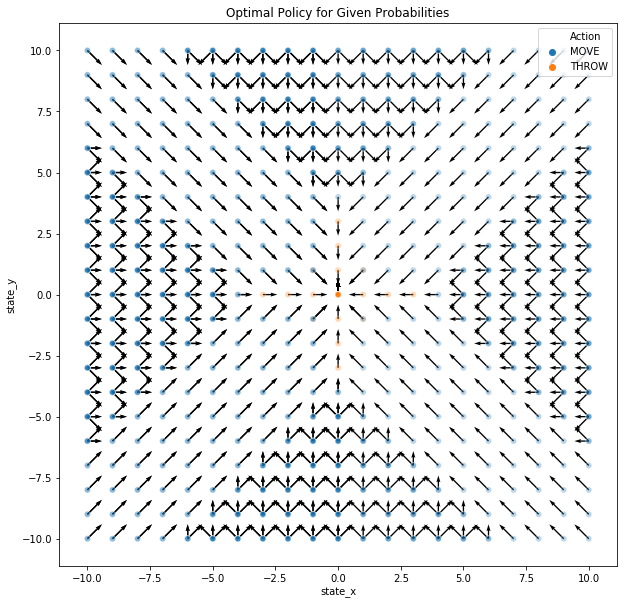

In [43]:
# Create Quiver plot showing current optimal policy in one cell
arrow_scale = 0.1

Q_table_VI_3 = state_sub_full.copy()

optimal_action_list = pd.DataFrame()
for x in range(0,21):
    state_x = int(-10 + x)
    for y in range(0,21):
        state_y = int(-10 + y)
        
        Q_table_VI_3
        
        for i in range(0,len(Q_table_VI_3[ (Q_table_VI_3['state_x']==state_x) & (Q_table_VI_3['state_y']==state_y) &  (Q_table_VI_3['Q'] == max(Q_table_VI_3[(Q_table_VI_3['state_x']==state_x) & 
                                                      (Q_table_VI_3['state_y']==state_y)]['Q']))].reset_index(drop=True)['move_dir'])):
            optimal_action = pd.DataFrame({'state_x':state_x, 'state_y': state_y, 
                                          'move_dir': Q_table_VI_3[ (Q_table_VI_3['state_x']==state_x) & (Q_table_VI_3['state_y']==state_y) &  (Q_table_VI_3['Q'] == max(Q_table_VI_3[(Q_table_VI_3['state_x']==state_x) & 
                                                          (Q_table_VI_3['state_y']==state_y)]['Q']))].reset_index(drop=True)['move_dir'][i],
                                          'throw_dir': Q_table_VI_3[ (Q_table_VI_3['state_x']==state_x) & (Q_table_VI_3['state_y']==state_y) &  (Q_table_VI_3['Q'] == max(Q_table_VI_3[(Q_table_VI_3['state_x']==state_x) & 
                                                          (Q_table_VI_3['state_y']==state_y)]['Q']))].reset_index(drop=True)['throw_dir'][0]},
                                         index = [state_y])
            optimal_action_list = optimal_action_list.append(optimal_action)
optimal_action_list = optimal_action_list.reset_index(drop=True)

optimal_action_list['Action'] = np.where( optimal_action_list['move_dir'] == 'none', 'THROW', 'MOVE'  )


optimal_action_list['move_x'] = np.where(optimal_action_list['move_dir'] == 0, int(0),
                                         np.where(optimal_action_list['move_dir'] == 1, int(1),
                                         np.where(optimal_action_list['move_dir'] == 2, int(1),
                                         np.where(optimal_action_list['move_dir'] == 3, int(1),
                                         np.where(optimal_action_list['move_dir'] == 4, int(0),
                                         np.where(optimal_action_list['move_dir'] == 5, int(-1),
                                         np.where(optimal_action_list['move_dir'] == 6, int(-1),
                                         np.where(optimal_action_list['move_dir'] == 7, int(-1),
                                         int(-1000)
                                        ))))))))
optimal_action_list['move_y'] = np.where(optimal_action_list['move_dir'] == 0, int(1),
                                         np.where(optimal_action_list['move_dir'] == 1, int(1),
                                         np.where(optimal_action_list['move_dir'] == 2, int(0),
                                         np.where(optimal_action_list['move_dir'] == 3, int(-1),
                                         np.where(optimal_action_list['move_dir'] == 4, int(-1),
                                         np.where(optimal_action_list['move_dir'] == 5, int(-1),
                                         np.where(optimal_action_list['move_dir'] == 6, int(0),
                                         np.where(optimal_action_list['move_dir'] == 7, int(1),
                                         int(-1000)
                                        ))))))))
optimal_action_list['throw_dir_2'] = np.where(optimal_action_list['throw_dir']=="none",int(-1000), optimal_action_list['throw_dir'])

# Define horizontal arrow component as 0.1*move direction or 0.1/-0.1 depending on throw direction
optimal_action_list['u'] = np.where(optimal_action_list['Action']=="MOVE", optimal_action_list['move_x']*arrow_scale,
                                    np.where(optimal_action_list['throw_dir_2']==0, 0,np.where(optimal_action_list['throw_dir_2']==180, 0,
                                    np.where(optimal_action_list['throw_dir_2']==90, arrow_scale ,np.where(optimal_action_list['throw_dir_2']==270, -arrow_scale,
                                    np.where(optimal_action_list['throw_dir_2']<180, arrow_scale,-arrow_scale))))))

# Define vertical arrow component based 0.1*move direciton or +/- u*tan(throw_dir) accordingly
optimal_action_list['v'] = np.where(optimal_action_list['Action']=="MOVE", optimal_action_list['move_y']*arrow_scale, 
                                    np.where(optimal_action_list['throw_dir_2']==0, arrow_scale,np.where(optimal_action_list['throw_dir_2']==180, -arrow_scale,
                                    np.where(optimal_action_list['throw_dir_2']==90, 0,np.where(optimal_action_list['throw_dir_2']==270, 0,
                                    optimal_action_list['u']/np.tan(np.deg2rad(optimal_action_list['throw_dir_2'].astype(np.float64))))))))

x = optimal_action_list['state_x']
y = optimal_action_list['state_y']
u = optimal_action_list['u'].values
v = optimal_action_list['v'].values
plt.figure(figsize=(10, 10))
plt.quiver(x,y,u,v,scale=0.5,scale_units='inches')
sns.scatterplot( x="state_x", y="state_y", data=optimal_action_list,  hue='Action', alpha = 0.3)
plt.title("Optimal Policy for Given Probabilities")
plt.show()



#### We repeat the process one last time for completion and save the quiver plot at each step for an animation

In [44]:
input_table = Q_table_VI.copy()
gamma = 0.8
num_repeats = 10

start_time = time.time()

output_metric_table = pd.DataFrame()
# Repeat until converges
for repeats in range(0,num_repeats):
    clear_output(wait=True)
    state_sub_full = pd.DataFrame()
    
    
    output_metric_table = output_metric_table.append(pd.DataFrame({'mean_Q':input_table['Q'].mean(), 
                                                                   'sum_Q': input_table['Q'].sum(),
                                                                   'mean_V':input_table[['state_x', 'state_y','V']].drop_duplicates(['state_x', 'state_y', 'V'])['V'].mean(),
                                                                   'sum_V': input_table[['state_x', 'state_y','V']].drop_duplicates(['state_x', 'state_y', 'V'])['V'].sum()}, index = [repeats]))
    
    
    # Iterate over all states defined by max - min of x times by max - min of y
    for x in range(0,21):
        state_x = -10 + x
        for y in range(0,21):
            state_y = -10 + y

            state_sub = input_table[ (input_table['state_x']==state_x) & (input_table['state_y']==state_y)]
            Q_sub_list = pd.DataFrame()
            for n, action in state_sub.iterrows():
                # Move action update Q
                if(action['throw_dir'] == "none"):
                    move_direction = action['move_dir']
                    #Map this to actual direction and find V(s) for next state
                    if(move_direction == 0):
                        move_x = 0
                        move_y = 1
                    elif(move_direction == 1):
                        move_x = 1
                        move_y = 1
                    elif(move_direction == 2):
                        move_x = 1
                        move_y = 0
                    elif(move_direction == 3):
                        move_x = 1
                        move_y = -1
                    elif(move_direction == 4):
                        move_x = 0
                        move_y = -1
                    elif(move_direction == 5):
                        move_x = -1
                        move_y = -1
                    elif(move_direction == 6):
                        move_x = -1
                        move_y = 0
                    elif(move_direction == 7):
                        move_x = -1
                        move_y = 1
                    Q = 1*(action['reward'] + gamma*max(input_table[ (input_table['state_x']==int(state_x+move_x)) & (input_table['state_y']==int(state_y+move_y))]['V']) )
                # Throw update Q +1 if sucessful throw or -1 if failed
                else:
                    Q = (action['prob']*(action['reward'] + gamma*1)) +  ((1-action['prob'])*(action['reward'] + gamma*-1))
                Q_sub_list = Q_sub_list.append(pd.DataFrame({'Q':Q}, index = [n]))
            state_sub['Q'] = Q_sub_list['Q']
            state_sub['V'] = max(state_sub['Q'])
            state_sub_full = state_sub_full.append(state_sub)
            
    
    
    ###
    # Create Quiver plot showing current optimal policy in one cell
    arrow_scale = 0.1

    Q_table_VI_3 = state_sub_full.copy()

    optimal_action_list = pd.DataFrame()
    for x in range(0,21):
        state_x = int(-10 + x)
        for y in range(0,21):
            state_y = int(-10 + y)

            Q_table_VI_3

            for i in range(0,len(Q_table_VI_3[ (Q_table_VI_3['state_x']==state_x) & (Q_table_VI_3['state_y']==state_y) &  (Q_table_VI_3['Q'] == max(Q_table_VI_3[(Q_table_VI_3['state_x']==state_x) & 
                                                      (Q_table_VI_3['state_y']==state_y)]['Q']))].reset_index(drop=True)['move_dir'])):
                optimal_action = pd.DataFrame({'state_x':state_x, 'state_y': state_y, 
                                              'move_dir': Q_table_VI_3[ (Q_table_VI_3['state_x']==state_x) & (Q_table_VI_3['state_y']==state_y) &  (Q_table_VI_3['Q'] == max(Q_table_VI_3[(Q_table_VI_3['state_x']==state_x) & 
                                                              (Q_table_VI_3['state_y']==state_y)]['Q']))].reset_index(drop=True)['move_dir'][i],
                                              'throw_dir': Q_table_VI_3[ (Q_table_VI_3['state_x']==state_x) & (Q_table_VI_3['state_y']==state_y) &  (Q_table_VI_3['Q'] == max(Q_table_VI_3[(Q_table_VI_3['state_x']==state_x) & 
                                                              (Q_table_VI_3['state_y']==state_y)]['Q']))].reset_index(drop=True)['throw_dir'][0]},
                                             index = [state_y])
                optimal_action_list = optimal_action_list.append(optimal_action)
    optimal_action_list = optimal_action_list.reset_index(drop=True)

    optimal_action_list['Action'] = np.where( optimal_action_list['move_dir'] == 'none', 'THROW', 'MOVE'  )


    optimal_action_list['move_x'] = np.where(optimal_action_list['move_dir'] == 0, int(0),
                                             np.where(optimal_action_list['move_dir'] == 1, int(1),
                                             np.where(optimal_action_list['move_dir'] == 2, int(1),
                                             np.where(optimal_action_list['move_dir'] == 3, int(1),
                                             np.where(optimal_action_list['move_dir'] == 4, int(0),
                                             np.where(optimal_action_list['move_dir'] == 5, int(-1),
                                             np.where(optimal_action_list['move_dir'] == 6, int(-1),
                                             np.where(optimal_action_list['move_dir'] == 7, int(-1),
                                             int(-1000)
                                            ))))))))
    optimal_action_list['move_y'] = np.where(optimal_action_list['move_dir'] == 0, int(1),
                                             np.where(optimal_action_list['move_dir'] == 1, int(1),
                                             np.where(optimal_action_list['move_dir'] == 2, int(0),
                                             np.where(optimal_action_list['move_dir'] == 3, int(-1),
                                             np.where(optimal_action_list['move_dir'] == 4, int(-1),
                                             np.where(optimal_action_list['move_dir'] == 5, int(-1),
                                             np.where(optimal_action_list['move_dir'] == 6, int(0),
                                             np.where(optimal_action_list['move_dir'] == 7, int(1),
                                             int(-1000)
                                            ))))))))
    optimal_action_list['throw_dir_2'] = np.where(optimal_action_list['throw_dir']=="none",int(-1000), optimal_action_list['throw_dir'])

    # Define horizontal arrow component as 0.1*move direction or 0.1/-0.1 depending on throw direction
    optimal_action_list['u'] = np.where(optimal_action_list['Action']=="MOVE", optimal_action_list['move_x']*arrow_scale,
                                        np.where(optimal_action_list['throw_dir_2']==0, 0,np.where(optimal_action_list['throw_dir_2']==180, 0,
                                        np.where(optimal_action_list['throw_dir_2']==90, arrow_scale ,np.where(optimal_action_list['throw_dir_2']==270, -arrow_scale,
                                        np.where(optimal_action_list['throw_dir_2']<180, arrow_scale,-arrow_scale))))))

    # Define vertical arrow component based 0.1*move direciton or +/- u*tan(throw_dir) accordingly
    optimal_action_list['v'] = np.where(optimal_action_list['Action']=="MOVE", optimal_action_list['move_y']*arrow_scale, 
                                        np.where(optimal_action_list['throw_dir_2']==0, arrow_scale,np.where(optimal_action_list['throw_dir_2']==180, -arrow_scale,
                                        np.where(optimal_action_list['throw_dir_2']==90, 0,np.where(optimal_action_list['throw_dir_2']==270, 0,
                                        optimal_action_list['u']/np.tan(np.deg2rad(optimal_action_list['throw_dir_2'].astype(np.float64))))))))



    x = optimal_action_list['state_x']
    y = optimal_action_list['state_y']
    u = optimal_action_list['u'].values
    v = optimal_action_list['v'].values
    plt.figure(figsize=(10, 10))
    plt.quiver(x,y,u,v,scale=0.5,scale_units='inches')
    sns.scatterplot( x="state_x", y="state_y", data=optimal_action_list,  hue='Action', alpha = 0.5)
    plt.title("Optimal Policy for Given Probabilities for iteration " +str(repeats))
    #plt.savefig('E:\\Documents\\RL\\RL from scratch v2\\QuiverPlots\\'+str(repeats)+'.png')   # save the figure to file
    plt.close() 

    ###
    input_table = state_sub_full.copy()
    print("Repeats completed: ", np.round((repeats+1)/num_repeats,2)*100, "%")
    
end_time = time.time()

print("total time taken this loop: ", np.round((end_time - start_time)/60,2), " minutes")

Repeats completed:  100.0 %
total time taken this loop:  49.64  minutes


#### Save Optimal Policy for Later Comparison

This final policy is the one we will consider optimal

In [45]:
# SAVE OPTIMAL POLICY FOR LATER COMPARISON
# This is the .csv saved as the dataset and will be used when we apply RL algorithms in later outputs for comparison
Optimal_Policy_VI = optimal_action_list.copy()
#Optimal_Policy_VI.to_csv('E:\Documents\RL\RL from scratch v2\OptimalPolicy_angletol=45.csv')

#### Change reward for each step to be equal to a small negative value. i.e. want to reach goal faster

Aside from changing the two previously mentioned parameters, we can also introduce rewards for each state-action pair. We could use this to define some bias in favour or against specific actions or could more generally decide we want the optimal policy to be more risky and increase the value of throwing. 

If, for example, we set the reward of each action equal to a small negative value, our calculations will value throwing slightly less than before but will consider moving even worse in some states. Therefore, more states will be incetivsed to throw instead of move.

In [46]:
input_table = Q_table_VI.copy()
input_table['reward'] = -0.05
gamma = 0.8
num_repeats = 10

start_time = time.time()

output_metric_table = pd.DataFrame()
# Repeat until converges
for repeats in range(0,num_repeats):
    clear_output(wait=True)
    state_sub_full = pd.DataFrame()
    
    
    output_metric_table = output_metric_table.append(pd.DataFrame({'mean_Q':input_table['Q'].mean(), 
                                                                   'sum_Q': input_table['Q'].sum(),
                                                                   'mean_V':input_table[['state_x', 'state_y','V']].drop_duplicates(['state_x', 'state_y', 'V'])['V'].mean(),
                                                                   'sum_V': input_table[['state_x', 'state_y','V']].drop_duplicates(['state_x', 'state_y', 'V'])['V'].sum()}, index = [repeats]))
    
    
    # Iterate over all states defined by max - min of x times by max - min of y
    for x in range(0,21):
        state_x = -10 + x
        for y in range(0,21):
            state_y = -10 + y

            state_sub = input_table[ (input_table['state_x']==state_x) & (input_table['state_y']==state_y)]
            Q_sub_list = pd.DataFrame()
            for n, action in state_sub.iterrows():
                # Move action update Q
                if(action['throw_dir'] == "none"):
                    move_direction = action['move_dir']
                    #Map this to actual direction and find V(s) for next state
                    if(move_direction == 0):
                        move_x = 0
                        move_y = 1
                    elif(move_direction == 1):
                        move_x = 1
                        move_y = 1
                    elif(move_direction == 2):
                        move_x = 1
                        move_y = 0
                    elif(move_direction == 3):
                        move_x = 1
                        move_y = -1
                    elif(move_direction == 4):
                        move_x = 0
                        move_y = -1
                    elif(move_direction == 5):
                        move_x = -1
                        move_y = -1
                    elif(move_direction == 6):
                        move_x = -1
                        move_y = 0
                    elif(move_direction == 7):
                        move_x = -1
                        move_y = 1
                    Q = 1*(action['reward'] + gamma*max(input_table[ (input_table['state_x']==int(state_x+move_x)) & (input_table['state_y']==int(state_y+move_y))]['V']) )
                # Throw update Q +1 if sucessful throw or -1 if failed
                else:
                    Q = (action['prob']*(action['reward'] + gamma*1)) +  ((1-action['prob'])*(action['reward'] + gamma*-1))
                Q_sub_list = Q_sub_list.append(pd.DataFrame({'Q':Q}, index = [n]))
            state_sub['Q'] = Q_sub_list['Q']
            state_sub['V'] = max(state_sub['Q'])
            state_sub_full = state_sub_full.append(state_sub)
            
    input_table = state_sub_full.copy()
    print("Repeats completed: ", np.round((repeats+1)/num_repeats,2)*100, "%")
    
end_time = time.time()

print("total time taken this loop: ", np.round((end_time - start_time)/60,2), " minutes")

Repeats completed:  100.0 %
total time taken this loop:  42.78  minutes


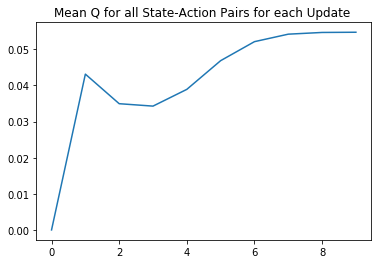

In [47]:
plt.plot(range(0,len(output_metric_table)), output_metric_table['mean_V'])
plt.title("Mean Q for all State-Action Pairs for each Update ")
plt.show()

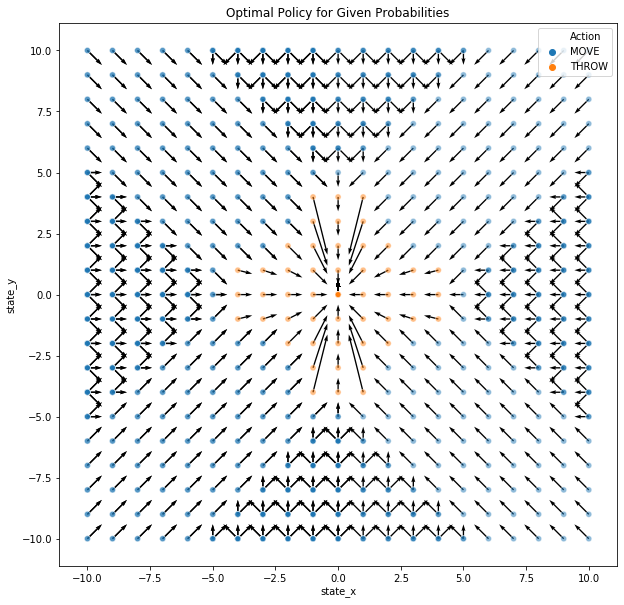

In [48]:
# Create Quiver plot showing current optimal policy in one cell
arrow_scale = 0.1

Q_table_VI_3 = state_sub_full.copy()

optimal_action_list = pd.DataFrame()
for x in range(0,21):
    state_x = int(-10 + x)
    for y in range(0,21):
        state_y = int(-10 + y)
        
        Q_table_VI_3
        
        for i in range(0,len(Q_table_VI_3[ (Q_table_VI_3['state_x']==state_x) & (Q_table_VI_3['state_y']==state_y) &  (Q_table_VI_3['Q'] == max(Q_table_VI_3[(Q_table_VI_3['state_x']==state_x) & 
                                                      (Q_table_VI_3['state_y']==state_y)]['Q']))].reset_index(drop=True)['move_dir'])):
            optimal_action = pd.DataFrame({'state_x':state_x, 'state_y': state_y, 
                                          'move_dir': Q_table_VI_3[ (Q_table_VI_3['state_x']==state_x) & (Q_table_VI_3['state_y']==state_y) &  (Q_table_VI_3['Q'] == max(Q_table_VI_3[(Q_table_VI_3['state_x']==state_x) & 
                                                          (Q_table_VI_3['state_y']==state_y)]['Q']))].reset_index(drop=True)['move_dir'][i],
                                          'throw_dir': Q_table_VI_3[ (Q_table_VI_3['state_x']==state_x) & (Q_table_VI_3['state_y']==state_y) &  (Q_table_VI_3['Q'] == max(Q_table_VI_3[(Q_table_VI_3['state_x']==state_x) & 
                                                          (Q_table_VI_3['state_y']==state_y)]['Q']))].reset_index(drop=True)['throw_dir'][0]},
                                         index = [state_y])
            optimal_action_list = optimal_action_list.append(optimal_action)
optimal_action_list = optimal_action_list.reset_index(drop=True)

optimal_action_list['Action'] = np.where( optimal_action_list['move_dir'] == 'none', 'THROW', 'MOVE'  )


optimal_action_list['move_x'] = np.where(optimal_action_list['move_dir'] == 0, int(0),
                                         np.where(optimal_action_list['move_dir'] == 1, int(1),
                                         np.where(optimal_action_list['move_dir'] == 2, int(1),
                                         np.where(optimal_action_list['move_dir'] == 3, int(1),
                                         np.where(optimal_action_list['move_dir'] == 4, int(0),
                                         np.where(optimal_action_list['move_dir'] == 5, int(-1),
                                         np.where(optimal_action_list['move_dir'] == 6, int(-1),
                                         np.where(optimal_action_list['move_dir'] == 7, int(-1),
                                         int(-1000)
                                        ))))))))
optimal_action_list['move_y'] = np.where(optimal_action_list['move_dir'] == 0, int(1),
                                         np.where(optimal_action_list['move_dir'] == 1, int(1),
                                         np.where(optimal_action_list['move_dir'] == 2, int(0),
                                         np.where(optimal_action_list['move_dir'] == 3, int(-1),
                                         np.where(optimal_action_list['move_dir'] == 4, int(-1),
                                         np.where(optimal_action_list['move_dir'] == 5, int(-1),
                                         np.where(optimal_action_list['move_dir'] == 6, int(0),
                                         np.where(optimal_action_list['move_dir'] == 7, int(1),
                                         int(-1000)
                                        ))))))))
optimal_action_list['throw_dir_2'] = np.where(optimal_action_list['throw_dir']=="none",int(-1000), optimal_action_list['throw_dir'])

# Define horizontal arrow component as 0.1*move direction or 0.1/-0.1 depending on throw direction
optimal_action_list['u'] = np.where(optimal_action_list['Action']=="MOVE", optimal_action_list['move_x']*arrow_scale,
                                    np.where(optimal_action_list['throw_dir_2']==0, 0,np.where(optimal_action_list['throw_dir_2']==180, 0,
                                    np.where(optimal_action_list['throw_dir_2']==90, arrow_scale ,np.where(optimal_action_list['throw_dir_2']==270, -arrow_scale,
                                    np.where(optimal_action_list['throw_dir_2']<180, arrow_scale,-arrow_scale))))))

# Define vertical arrow component based 0.1*move direciton or +/- u*tan(throw_dir) accordingly
optimal_action_list['v'] = np.where(optimal_action_list['Action']=="MOVE", optimal_action_list['move_y']*arrow_scale, 
                                    np.where(optimal_action_list['throw_dir_2']==0, arrow_scale,np.where(optimal_action_list['throw_dir_2']==180, -arrow_scale,
                                    np.where(optimal_action_list['throw_dir_2']==90, 0,np.where(optimal_action_list['throw_dir_2']==270, 0,
                                    optimal_action_list['u']/np.tan(np.deg2rad(optimal_action_list['throw_dir_2'].astype(np.float64))))))))

x = optimal_action_list['state_x']
y = optimal_action_list['state_y']
u = optimal_action_list['u'].values
v = optimal_action_list['v'].values
plt.figure(figsize=(10, 10))
plt.quiver(x,y,u,v,scale=0.5,scale_units='inches')
sns.scatterplot( x="state_x", y="state_y", data=optimal_action_list,  hue='Action', alpha = 0.5)
plt.title("Optimal Policy for Given Probabilities")
plt.show()



### Conclusion

We have defined the environment completely within Part 2 and now have the optimal policy calculated using value-iteration. The next step is to try and find the optimal policy using RL given we don't actually have the probabilities for each state-action pair. 

In the next notebook, I will show how this can be computed using Q-learning with more detailed analysis of parameters.